I needed to familiarize myself with the literature on science entrepreneurship (for reasons I'm going to explain soon). After delving into bibliometrics and doing literature review repetitively for my PhD, I already have a system to efficiently introduce myself to a new literature. In this post, I will explain my process, hoping it helps others who are also entering a new field.

I typically follow these steps:
1. Explore the Web of Knowledge using a keyword search
2. Explore data in Python
3. Create visualizations using VosViewer

The first step for me is usually just trying out different keywords in the Web of Knowledge. I then browse the first page of the latest articles and the top cited articles. I try to check whether these are related to my topic of interest. 

For this topic of science entrepreneurship, I settled with the following keywords. I also narrowed it down to the management journals that I know are relevant to technology and innovation management and just general management. Moreover, I was just interested in the papers published from 2010. Below was my keyword search:

>TS=(science OR technology ) AND TS=(startup* OR "start up*" OR "new venture*" OR entrepreneur* OR "new firm*" OR "spin off*" OR spinoff* OR SME OR SMEs) AND SO=(RESEARCH POLICY OR R D MANAGEMENT OR STRATEGIC MANAGEMENT JOURNAL OR JOURNAL OF PRODUCT INNOVATION MANAGEMENT OR ACADEMY OF MANAGEMENT REVIEW OR ACADEMY OF MANAGEMENT JOURNAL OR TECHNOVATION OR SCIENTOMETRICS OR TECHNOLOGICAL FORECASTING "AND" SOCIAL CHANGE OR TECHNOLOGY ANALYSIS STRATEGIC MANAGEMENT OR ORGANIZATION SCIENCE OR ADMINISTRATIVE SCIENCE QUARTERLY OR JOURNAL OF BUSINESS VENTURING OR INDUSTRY "AND" INNOVATION OR STRATEGIC ENTREPRENEURSHIP JOURNAL OR JOURNAL OF TECHNOLOGY TRANSFER OR JOURNAL OF ENGINEERING "AND" TECHNOLOGY MANAGEMENT OR JOURNAL OF MANAGEMENT OR JOURNAL OF MANAGEMENT STUDIES OR RESEARCH TECHNOLOGY MANAGEMENT OR ENTREPRENEURSHIP THEORY "AND" PRACTICE OR ACADEMY OF MANAGEMENT ANNALS OR ACADEMY OF MANAGEMENT PERSPECTIVES OR JOURNAL OF BUSINESS RESEARCH OR BRITISH JOURNAL OF MANAGEMENT OR EUROPEAN JOURNAL OF MANAGEMENT OR MANAGEMENT SCIENCE)

After exploring the results, I then downloaded the articles. These amounted to 1412 articles in total. Since WOS only allowed downloading of 500 at a time, I named these files 1-500.txt, 501-1000.txt and so on. I saved all the files in a folder (named Raw in this case) in my computer. 

# Data Exploration in Python

In the following, I show the code to import the data into Python and format the articles into a pandas dataframe. 

In [1]:
import re, csv, os 
import pandas as pd
import numpy as np
import nltk
import math
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
from collections import Counter

columnnames =['PT','AU','DE', 'AF','TI','SO','LA','DT','ID','AB','C1','RP','EM','CR','NR','TC','U1','PU','PI','PA','SN','EI','J9','JI','PD','PY','VL','IS','BP','EP','DI','PG','WC','SC','GA','UT']

def convertWOScsv(filename):
    openfile = open(filename, encoding='latin-1')
    sampledata = openfile.read()
    # divide into list of records 
    individualrecords = sampledata.split('\n\n')
    databaseofWOS = []
    for recordindividual in individualrecords:
        onefile = {}
        for x in columnnames:
            everyrow = re.compile('\n'+x + ' ' + '((.*?))\n[A-Z][A-Z1]', re.DOTALL)
            rowsdivision = everyrow.search(recordindividual)
            if rowsdivision:
                onefile[x] = rowsdivision.group(1)
        databaseofWOS.append(onefile)
    return databaseofWOS

def massconvertWOS(folder):
    publicationslist = []
    for file in os.listdir(folder):
        if file.endswith('.txt'):
            converttotable = convertWOScsv(folder + '\\' + file)
            publicationslist += converttotable
    publicationslist = pd.DataFrame(publicationslist)
    publicationslist.dropna(how='all', inplace=True)
    publicationslist.reset_index(drop=True, inplace=True)
    publicationslist['PY'] =publicationslist['PY'].fillna('').replace('', '2019').astype(int)
    publicationslist['TC'] = publicationslist['TC'].apply(lambda x: int(x.split('\n')[0]))
    return publicationslist
 
df = massconvertWOS('Raw')
df = df.drop_duplicates('UT').reset_index(drop=True)

I preview some of the articles that I was able to download below. I chose the relevant columns to show. 

In [2]:
print('Number of Articles:', df.shape[0])
df.head()[['TI', 'AU', 'SO', 'PY']]

Number of Articles: 1412


,TI,AU,SO,PY
0,Non-linear effects of technological competence...,"Deligianni, I\n Voudouris, I\n Spanos, Y\n...",TECHNOVATION,2019
1,Creating new products from old ones: Consumer ...,"Robson, K\n Wilson, M\n Pitt, L",TECHNOVATION,2019
2,What company characteristics are associated wi...,"Koski, H\n Pajarinen, M\n Rouvinen, P",INDUSTRY AND INNOVATION,2019
3,Through the Looking-Glass: The Impact of Regio...,"Vedula, S\n York, JG\n Corbett, AC",JOURNAL OF MANAGEMENT STUDIES,2019
4,The role of incubators in overcoming technolog...,"Yusubova, A\n Andries, P\n Clarysse, B",R & D MANAGEMENT,2019


WOS is smart in the sense that even if the text does not contain the keywords you said, they still may include papers because they sense that these are relevant papers. To filter out these papers that did not contain the keywords I wanted, I further filtered the dataset by checking the title, abstract and author-selected keywords. Moreover, let's remove articles without any citations.

In [3]:
df["txt"] = df["TI"].fillna("") + " " + df["DE"].fillna("") + " " + df["AB"].fillna("")
df["txt"] = df["txt"].apply(lambda x: x.replace('-', ' '))
df = df[df['txt'].apply(lambda x: any([y in x.lower() for y in ['scien', 'technolog']]))]
df = df[df['txt'].apply(lambda x: any([y in x.lower() for y in ['startup', 'start up', 'new venture', 'entrepreneur', 'new firm', 'spin off',
                                                                'spinoff', 'sme ', 'smes ']]))]
df = df[~df['CR'].isnull()] 
print('Number of Articles:', df.shape[0])

Number of Articles: 846


I can plot the number of articles over time

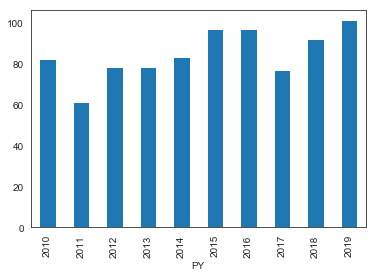

In [4]:
df.groupby('PY').size().plot(kind='bar')

I can look at the breakdown per journal

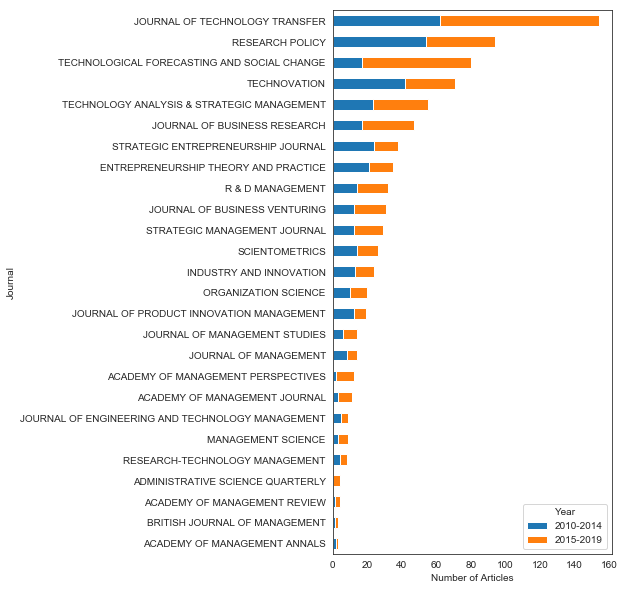

In [5]:
#df.groupby('SO').size().sort_values().plot(kind='barh', figsize=[5,10])
soplot = df.pivot_table(index='PY', columns='SO', aggfunc='size').fillna(0) #.reset_index()
soplot = soplot[soplot.sum(axis=0).sort_values().index].reset_index().rename(columns={'PY':'Year'})
soplot['Year'] = pd.cut(soplot['Year'], [0, 2014, 2019], labels=['2010-2014', '2015-2019'])
soplot.groupby('Year').sum().T.plot(kind='barh', stacked=True, figsize=[5,10])
plt.ylabel('Journal'), plt.xlabel('Number of Articles')
plt.show()

I can look at the top cited articles. This shows what are the foundational material that I should know before delving into the topic.

In [6]:
topcited = df['CR'].fillna('').apply(lambda x: [y.strip() for y in x.split('\n')]).sum()
pd.value_counts(topcited).head(10)

COHEN WM, 1990, ADMIN SCI QUART, V35, P128, DOI 10.2307/2393553                  115
Shane S, 2004, NEW HORIZ ENTREP, P1                                               88
Shane S, 2000, ACAD MANAGE REV, V25, P217, DOI 10.5465/amr.2000.2791611           87
Rothaermel FT, 2007, IND CORP CHANGE, V16, P691, DOI 10.1093/icc/dtm023           86
BARNEY J, 1991, J MANAGE, V17, P99, DOI 10.1177/014920639101700108                81
Shane S, 2000, ORGAN SCI, V11, P448, DOI 10.1287/orsc.11.4.448.14602              78
TEECE DJ, 1986, RES POLICY, V15, P285, DOI 10.1016/0048-7333(86)90027-2           77
Di Gregorio D, 2003, RES POLICY, V32, P209, DOI 10.1016/S0048-7333(02)00097-5     77
EISENHARDT KM, 1989, ACAD MANAGE REV, V14, P532, DOI 10.2307/258557               75
Nelson R.R., 1982, EVOLUTIONARY THEORY                                            69
dtype: int64

The articles above are not really very specific to our topic of interest. These are foundational papers in innovation/management. To explore those papers that are more relevant to our topic, what I can do then is find which is the most cited within the papers in this dataset, meaning hey include the keywords that I'm interested in. This is the internal citation of the papers.

In [7]:
def createinttc(df):
    df["CRparsed"] = df["CR"].fillna('').str.lower().astype(str)
    df["DI"] = df["DI"].fillna('').str.lower()
    df["intTC"] = df["DI"].apply(lambda x: sum([x in y for y in df["CRparsed"]]) if x!="" else 0)
    df["CRparsed"] = df["CR"].astype(str).apply(lambda x: [y.strip().lower() for y in x.split('\n')])
    return df

df = createinttc(df).reset_index(drop=True)

In [8]:
df.sort_values('intTC', ascending=False)[['TI', 'AU', 'SO', 'PY', 'intTC']].head(10)

,TI,AU,SO,PY,intTC
401,30 years after Bayh-Dole: Reassessing academic...,"Grimaldi, R\n Kenney, M\n Siegel, DS\n W...",RESEARCH POLICY,2011,45
301,Academic engagement and commercialisation: A r...,"Perkmann, M\n Tartari, V\n McKelvey, M\n ...",RESEARCH POLICY,2013,41
428,Why do academics engage with industry? The ent...,"D'Este, P\n Perkmann, M",JOURNAL OF TECHNOLOGY TRANSFER,2011,32
402,"The impact of entrepreneurial capacity, experi...","Clarysse, B\n Tartari, V\n Salter, A",RESEARCH POLICY,2011,26
407,ENDOGENOUS GROWTH THROUGH KNOWLEDGE SPILLOVERS...,"Delmar, F\n Wennberg, K\n Hellerstedt, K",STRATEGIC ENTREPRENEURSHIP JOURNAL,2011,24
430,Entrepreneurial effectiveness of European univ...,"Van Looy, B\n Landoni, P\n Callaert, J\n ...",RESEARCH POLICY,2011,23
398,The Bayh-Dole Act and scientist entrepreneurship,"Aldridge, TT\n Audretsch, D",RESEARCH POLICY,2011,20
400,The effectiveness of university knowledge spil...,"Wennberg, K\n Wiklund, J\n Wright, M",RESEARCH POLICY,2011,19
515,Convergence or path dependency in policies to ...,"Mustar, P\n Wright, M",JOURNAL OF TECHNOLOGY TRANSFER,2010,19
413,"Entrepreneurial Origin, Technological Knowledg...","Clarysse, B\n Wright, M\n Van de Velde, E",JOURNAL OF MANAGEMENT STUDIES,2011,19


A complementary approach is to look at the articles that are citing the most the rest of the papers in the dataset. These allows us to see which reviews already integrates the studies within our dataset. We can then start reading from this set of papers as they cover already a lot of the other papers in the dataset.

In [9]:
doilist = [y for y in df['DI'].dropna().tolist() if y!='']
df['Citing'] = df['CR'].apply(lambda x: len([y for y in doilist if y in x]))
df.sort_values('Citing', ascending=False)[['TI', 'AU', 'SO' , 'PY',  'Citing', ]].head(10)

,TI,AU,SO,PY,Citing
139,Conceptualizing academic entrepreneurship ecos...,"Hayter, CS\n Nelson, AJ\n Zayed, S\n O'C...",JOURNAL OF TECHNOLOGY TRANSFER,2018,75
168,THE PSYCHOLOGICAL FOUNDATIONS OF UNIVERSITY SC...,"Hmieleski, KM\n Powell, EE",ACADEMY OF MANAGEMENT PERSPECTIVES,2018,33
138,Re-thinking university spin-off: a critical li...,"Miranda, FJ\n Chamorro, A\n Rubio, S",JOURNAL OF TECHNOLOGY TRANSFER,2018,31
122,Public policy for academic entrepreneurship in...,"Sandstrom, C\n Wennberg, K\n Wallin, MW\n ...",JOURNAL OF TECHNOLOGY TRANSFER,2018,28
37,Opening the black box of academic entrepreneur...,"Skute, I",SCIENTOMETRICS,2019,28
166,RETHINKING THE COMMERCIALIZATION OF PUBLIC SCI...,"Fini, R\n Rasmussen, E\n Siegel, D\n Wik...",ACADEMY OF MANAGEMENT PERSPECTIVES,2018,25
68,The technology transfer ecosystem in academia....,"Good, M\n Knockaert, M\n Soppe, B\n Wrig...",TECHNOVATION,2019,24
40,Theories from the Lab: How Research on Science...,"Fini, R\n Rasmussen, E\n Wiklund, J\n Wr...",JOURNAL OF MANAGEMENT STUDIES,2019,22
659,How can universities facilitate academic spin-...,"Rasmussen, E\n Wright, M",JOURNAL OF TECHNOLOGY TRANSFER,2015,21
73,Stimulating academic patenting in a university...,"Backs, S\n Gunther, M\n Stummer, C",JOURNAL OF TECHNOLOGY TRANSFER,2019,21


# Bibliometric Analysis in VosViewer

To create visualizations of the paper, we do the following steps. First, we can export the filtered dataset into a text file. 

In [10]:
def convertWOStext(dataframe, outputtext):
    dataframe["PY"]=dataframe["PY"].astype(int)
    txtresult = ""
    for y in range(0, len(dataframe)):
        for x in columnnames:
            if dataframe[x].iloc[y] != np.nan:
                txtresult += x + " " + str(dataframe[x].iloc[y]) + "\n"
        txtresult += "ER\n\n"
    f = open(outputtext, "w", encoding='utf-8')
    f.write(txtresult)
    f.close()

convertWOStext(df, 'df.txt')

We can then open the file in VosViewer. From there, we can create various visualizations. I like using bibliographic coupling to map all the papers in the dataset 
![VosViewer Original](Figures/Vos_initial.png)

I saved the file in VosViewer. This gives you two files, one has the data on each document and the second file has the network data. We modify these files to make certain changes. First, the citations above reflect their citations from all the papers outside the dataset. I want the internal citations to be shown so I replace it.

In [11]:
def createvosfile1(filename, df, updatecit= False, newclusters = False, newname=None):
    vosfile1  = pd.read_csv(filename, sep="\t")
    voscolumns = vosfile1.columns
    vosfile1["title"] = vosfile1["description"].apply(lambda x: x.split("Title:</td><td>")[1])
    vosfile1["title"] = vosfile1["title"].apply(lambda x: x.split("</td></tr>")[0])
    df["TI2"] = df["TI"].apply(lambda x: " ".join(x.lower().split()))
    vosfile1 = vosfile1.merge(df[[x for x in df.columns if x not in voscolumns]], how="left", left_on="title", right_on="TI2")
    vosfile1["txt"] = vosfile1["TI"].fillna(" ") + " " + vosfile1["DE"].fillna(" ") + " " + vosfile1["AB"].fillna(" ")  
    vosfile1["txt"] = vosfile1["txt"].apply(lambda x: x.lower())
    vosfile1["weight<Citations>"] = vosfile1["intTC"].fillna(0)
    vosfile1 = vosfile1.drop_duplicates('id')
    vosfile1['id'] = vosfile1.reset_index().index + 1
    if newclusters == True:
        vosfile1['cluster'] = artclusters
    if updatecit == True:
        vosfile1[voscolumns].to_csv(newname, sep="\t", index=False)
    return vosfile1

df = createvosfile1('Processed\VosViewer_1_Original.txt', df, newname='Processed\VosViewer_1_intCit.txt', updatecit= True, newclusters=False)

The above network just uses the citation data of the publications. To improve it, I like integrating the textual data from the title, abstract and keywords. I followed the steps suggested here for cleaning the text (https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/). I then combine these two measures to allow for hybrid clustering 
>Liu, Xinhai, Shi Yu, Frizo Janssens, Wolfgang Glänzel, Yves Moreau, and Bart De Moor. "Weighted hybrid clustering by combining text mining and bibliometrics on a large‐scale journal database." Journal of the American Society for Information Science and Technology 61, no. 6 (2010): 1105-1119. 

In [12]:
#Bibliometric coupling
from scipy.sparse import coo_matrix
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

def createbibnet(df):
    allsources = Counter(df['CRparsed'].sum())
    allsources  = [x for x in allsources if allsources[x]>1]
    dfcr = df['CRparsed'].reset_index(drop=True)
    dfnet = []
    i=0
    for n in allsources:
        [dfnet.append([i, y]) for y in dfcr[dfcr.apply(lambda x: n in x)].index]
        i+=1
    dfnet_matrix = coo_matrix(([1] * len(dfnet), ([x[1] for x in dfnet], [x[0] for x in dfnet])), 
                              shape=(dfcr.shape[0], len(allsources)))
    return cosine_similarity(dfnet_matrix, dfnet_matrix)

#Lexical Coupling
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from gensim.models.phrases import Phrases, Phraser

def clean(doc):
    stop = set(stopwords.words('english'))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    normalized = " ".join([x for x in normalized.split() if not any(c.isdigit() for c in x)])
    normalized = " ".join([x for x in normalized.split() if len(x)>3])
    return normalized

def bigrams(docs):
    phrases = Phrases(docs)
    bigram = Phraser(phrases)
    docs = docs.apply(lambda x: bigram[x])
    phrases = Phrases(docs)
    trigram = Phraser(phrases)
    docs = docs.apply(lambda x: trigram[x])
    return docs

def createtfidf(df, sheet_name):
    df["lemma"] = df["txt"].apply(lambda x: clean(x).split())
    df["lemma"] = bigrams(df["lemma"])
    vect = TfidfVectorizer(min_df=1)
    tfidftemp = vect.fit_transform([" ".join(x) for x in df["lemma"]])
    return cosine_similarity(tfidftemp) 

#Hybrid network
def createhybridnet(df, weightlex, sheet_name='Sheet1'):
    bibnet = createbibnet(df)
    tfidftemp = createtfidf(df, sheet_name)
    hybnet = pd.DataFrame(np.cos((1-weightlex) * np.arccos(bibnet) + weightlex *  np.arccos(tfidftemp))).fillna(0)
    return hybnet

from itertools import combinations
def createvosviewer2filefromhybrid(hybridlexcit, minimumlink, outputfilename):
    forvisuals = []
    for x, y in combinations(hybridlexcit.index, 2):
        val = int(hybridlexcit.loc[x,y]*100)
        if val > minimumlink:
            forvisuals.append([x, y, val])
    forvisuals = pd.DataFrame(forvisuals)
    forvisuals[0] = forvisuals[0] + 1
    forvisuals[1] = forvisuals[1] + 1
    forvisuals.to_csv(outputfilename, index=False, header=False)
    
dfhybrid = createhybridnet(df, 0.5)
createvosviewer2filefromhybrid(dfhybrid, 0, r'Processed/VosViewer_2_Hybrid.txt')

C:\Users\ara730\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\ara730\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in arccos


If we reimport these modified files to VosViewer. We come up with this visualization which incorporates both textual and citation data.

![Hybrid Network](Figures/Vos_Hybrid.png)

I can then spend tons of time just exploring the network. I look at the papers in each cluster. I check which papers have high citations. I can do this also with the help of python. We can update the clustering using the one generated by VosViewer.

In [13]:
df = createvosfile1('Processed/VosViewer_1_Clus.txt', df)

In [14]:
df[df['cluster']==1].sort_values('intTC', ascending=False)[['TI', 'AU', 'SO', 'PY', 'intTC']].head(10)

,TI,AU,SO,PY,intTC
404,ENDOGENOUS GROWTH THROUGH KNOWLEDGE SPILLOVERS...,"Delmar, F\n Wennberg, K\n Hellerstedt, K",STRATEGIC ENTREPRENEURSHIP JOURNAL,2011,24
500,Cognitive Processes of Opportunity Recognition...,"Gregoire, DA\n Barr, PS\n Shepherd, DA",ORGANIZATION SCIENCE,2010,11
439,Managing knowledge assets under conditions of ...,"Allarakhia, M\n Steven, W",TECHNOVATION,2011,10
353,Technology entrepreneurship,"Beckman, C\n Eisenhardt, K\n Kotha, S\n ...",STRATEGIC ENTREPRENEURSHIP JOURNAL,2012,9
484,IAMOT and Education: Defining a Technology and...,"Yanez, M\n Khalil, TM\n Walsh, ST",TECHNOVATION,2010,8
343,TECHNOLOGY-MARKET COMBINATIONS AND THE IDENTIF...,"Gregoire, DA\n Shepherd, DA",ACADEMY OF MANAGEMENT JOURNAL,2012,8
443,The Strategy-Technology Firm Fit Audit: A guid...,"Walsh, ST\n Linton, JD",TECHNOLOGICAL FORECASTING AND SOCIAL CHANGE,2011,8
411,The Cognitive Perspective in Entrepreneurship:...,"Gregoire, DA\n Corbett, AC\n McMullen, JS",JOURNAL OF MANAGEMENT STUDIES,2011,8
596,Technology Business Incubation: An overview of...,"Mian, S\n Lamine, W\n Fayolle, A",TECHNOVATION,2016,6
303,Local responses to global technological change...,"Fink, M\n Lang, R\n Harms, R",TECHNOLOGICAL FORECASTING AND SOCIAL CHANGE,2013,6


In [15]:
df[df['cluster']==2].sort_values('intTC', ascending=False)[['TI', 'AU', 'SO', 'PY', 'intTC']].head(10)

,TI,AU,SO,PY,intTC
410,"Entrepreneurial Origin, Technological Knowledg...","Clarysse, B\n Wright, M\n Van de Velde, E",JOURNAL OF MANAGEMENT STUDIES,2011,19
461,On growth drivers of high-tech start-ups: Expl...,"Colombo, MG\n Grilli, L",JOURNAL OF BUSINESS VENTURING,2010,17
387,WHEN DOES CORPORATE VENTURE CAPITAL ADD VALUE ...,"Park, HD\n Steensma, HK",STRATEGIC MANAGEMENT JOURNAL,2012,10
514,The M&A dynamics of European science-based ent...,"Bonardo, D\n Paleari, S\n Vismara, S",JOURNAL OF TECHNOLOGY TRANSFER,2010,9
506,The role of incubator interactions in assistin...,"Scillitoe, JL\n Chakrabarti, AK",TECHNOVATION,2010,9
423,EXPLAINING GROWTH PATHS OF YOUNG TECHNOLOGY-BA...,"Clarysse, B\n Bruneel, J\n Wright, M",STRATEGIC ENTREPRENEURSHIP JOURNAL,2011,9
574,CHANGING WITH THE TIMES: AN INTEGRATED VIEW OF...,"Fisher, G\n Kotha, S\n Lahiri, A",ACADEMY OF MANAGEMENT REVIEW,2016,9
354,Amphibious entrepreneurs and the emergence of ...,"Powell, WW\n Sandholtz, KW",STRATEGIC ENTREPRENEURSHIP JOURNAL,2012,8
507,A longitudinal study of success and failure am...,"Gurdon, MA\n Samsom, KJ",TECHNOVATION,2010,8
324,Are You Experienced or Are You Talented?: When...,"Eesley, CE\n Roberts, EB",STRATEGIC ENTREPRENEURSHIP JOURNAL,2012,8


In [16]:
df[df['cluster']==3].sort_values('intTC', ascending=False)[['TI', 'AU', 'SO', 'PY', 'intTC']].head(10)

,TI,AU,SO,PY,intTC
398,30 years after Bayh-Dole: Reassessing academic...,"Grimaldi, R\n Kenney, M\n Siegel, DS\n W...",RESEARCH POLICY,2011,45
298,Academic engagement and commercialisation: A r...,"Perkmann, M\n Tartari, V\n McKelvey, M\n ...",RESEARCH POLICY,2013,41
425,Why do academics engage with industry? The ent...,"D'Este, P\n Perkmann, M",JOURNAL OF TECHNOLOGY TRANSFER,2011,32
399,"The impact of entrepreneurial capacity, experi...","Clarysse, B\n Tartari, V\n Salter, A",RESEARCH POLICY,2011,26
427,Entrepreneurial effectiveness of European univ...,"Van Looy, B\n Landoni, P\n Callaert, J\n ...",RESEARCH POLICY,2011,23
395,The Bayh-Dole Act and scientist entrepreneurship,"Aldridge, TT\n Audretsch, D",RESEARCH POLICY,2011,20
397,The effectiveness of university knowledge spil...,"Wennberg, K\n Wiklund, J\n Wright, M",RESEARCH POLICY,2011,19
392,What motivates academic scientists to engage i...,"Lam, A",RESEARCH POLICY,2011,19
511,Convergence or path dependency in policies to ...,"Mustar, P\n Wright, M",JOURNAL OF TECHNOLOGY TRANSFER,2010,19
479,A knowledge-based typology of university spin-...,"Bathelt, H\n Kogler, DF\n Munro, AK",TECHNOVATION,2010,18
